# Forewords

# Import and definitions

In [1]:
from pathlib import Path
import sys
import os
import yaml
import json
from typing import Dict, Set
import itertools as itt

from dotmap import DotMap
import pandas as pd
import numpy as np
import scipy.stats

import sklearn.metrics

import networkx as nx

sys.path.insert(0, "../../../code/")

from plotting_config import *

sys.path.insert(0, "../code/")

import lib_edges

import matplotlib as mpl

In [2]:
sys.path.insert(0, "../../../code/pydea/pyDEA/")
import pyDEA

# Load

In [3]:
DATA = DotMap()

In [4]:
RESULTS_DIR = Path("../results")

## Config

In [5]:
fp = "../config/config.yaml"
with open(fp, 'r') as in_f:
    config_networks = yaml.load(in_f, Loader=yaml.SafeLoader)

run_ids = list(config_networks["runs"].keys())
run_ids = {i: r for i, r in enumerate(run_ids)}

DATA['configs'] = config_networks

for i, r in run_ids.items():
    print(i, r)

0 UP_mirnas_ivt_100pct.de_proteins.edges_10pct_w_concordancestatusMirnaOnly
1 UP_mirnas_ivt_100pct.relaxed_proteins.edges_10pct_w_concordancestatusMirnaOnly
2 UP_mirnas_ivt_100pct.relaxed_proteins.edges_1pct_w_concordancestatusMirnaOnly
3 UP_mirnas_ivt_100pct.de_proteins.edges_1pct_w_concordancestatusMirnaOnly
4 UP_mirnas_ivt_100pct.relaxed_proteins.edges_0.5pct_w_concordancestatusMirnaOnly
5 UP_mirnas_ivvivt_concordant_clusters.de_proteins.edges_10pct_w_concordancestatusMirnaOnly
6 UP_mirnas_ivvivt_concordant_clusters.relaxed_proteins.edges_10pct_w_concordancestatusMirnaOnly
7 UP_mirnas_ivvivt_concordant_clusters.de_proteins.edges_1pct_w_concordancestatusMirnaOnly
8 UP_mirnas_ivvivt_concordant_clusters.relaxed_proteins.edges_1pct_w_concordancestatusMirnaOnly
9 UP_mirnas_ivvivt_concordant_clusters.relaxed_proteins.edges_mt10pct_ppi1pct_w_concordancestatusMirnaOnly
10 UP_mirnas_ivvivt_concordant_clusters.de_proteins.edges_mt10pct_ppi1pct_w_concordancestatusMirnaOnly
11 UP_mirnas_ivvivt_

In [6]:
selected_run_ids = [
    2, # IVT
    9, # IVVIVT
    13, # IVVIVT relaxed
]

## Proteomics DEA

### ivt

In [7]:
path = "../../../storage/MANUAL_DATA/DEA-proteomics_E14_Pause_VS_E14_WT_FC.tsv"
df = pd.read_csv(path, header=0, index_col=0, sep="\t")

DATA['prot']['dea'] = df

In [8]:
path = "../../prot_ivt_DEA/results/2021-05-31/X_prot_medScale_noDup.tsv"
df = pd.read_csv(path, sep="\t")
DATA['prot']['intensities_medscaled'] = df

In [9]:
DATA['prot']['intensities_medscaled'].head(3)

,Gene names,E14_Pause1,E14_Pause2,E14_Pause3,E14_WT1,E14_WT2,E14_WT3
0,Ahnak,14.300864,12.780124,14.658376,14.799866,15.850174,14.289079
1,Dync1h1,7.078365,8.436056,7.182832,7.038017,5.780663,6.503684
2,Flna,23.305991,25.268246,26.524001,16.692011,15.076187,14.253745


In [10]:
prot_ivt_dea = DATA['prot']['dea']
DEA_prot_ivt = pyDEA.DE_results(
    prot_ivt_dea.loc[lambda df: (
        (df['DE_status'].isin(['UP','DOWN']) & df['significant']) |
        (~df['DE_status'].isin(['UP','DOWN']) & ~df['significant'])
    ),:],
    'paused',
    'ctrl',
    np.log2(1.5),
    0.1,
    "",
    process_significant='compute',
)

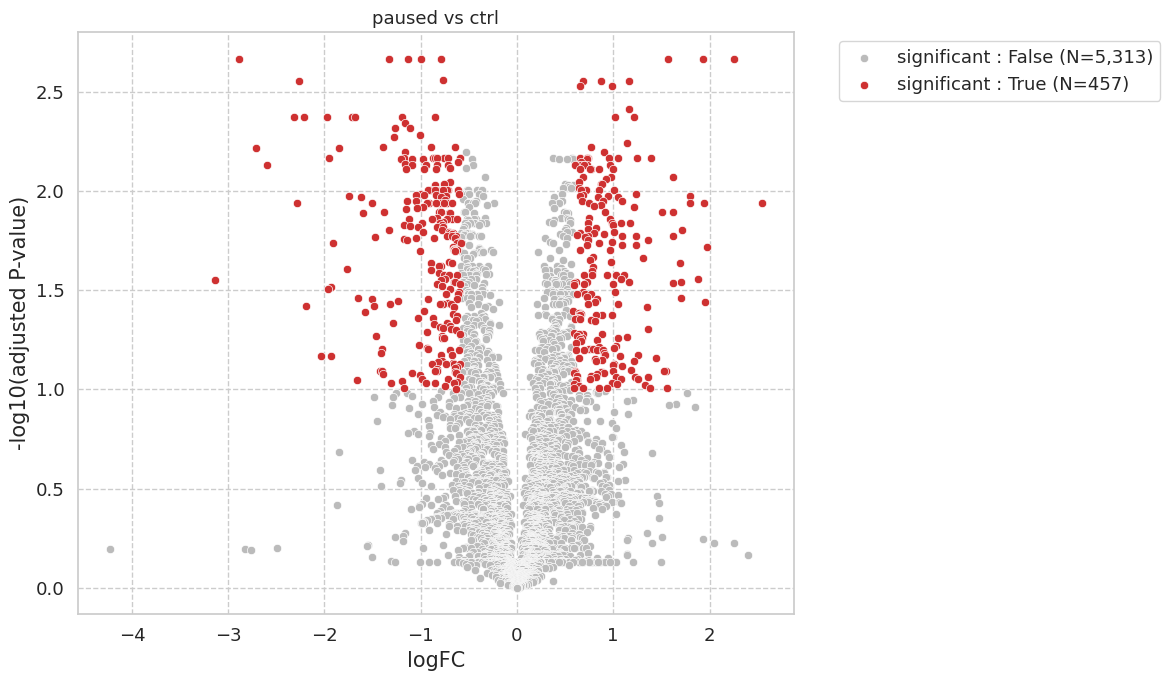

In [11]:
DEA_prot_ivt.volcano_plot()

## miRNA DEA

In [18]:
path = "../../miRNA_ivv_ivt_INTEGRATION/results/RNAseq-DEA_IVV-IVT_clustering/latest/IVV-IVT_E14-ICM/table_w_annotated_clusters.raw_logFC.tsv"
mirna_dea_merged = pd.read_csv(path, header=0, index_col=0, sep="\t")
display(mirna_dea_merged.head(3))

,diapaused_ICM,mTor_ICM,paused_E14,cluster
mmu-let-7b-5p,-0.284797,1.640406,-2.586675,0
mmu-let-7d-3p,0.224289,0.199054,-1.123651,0
mmu-let-7d-5p,1.994476,0.392090,0.781504,1


In [19]:
path = "../../miRNA_ivv_ivt_DEA/datasets/raw_counts_noDup_FULL.tsv"
mirna_cts = pd.read_csv(path, sep="\t", header=0, index_col=0)
display(mirna_cts.head(3))

,di1,di2,di3,dt1,dt2,dt3,mi1,mi2,mi3,mt1,...,tw2,tp2,tw3,tp3,ew1,ep1,ew2,ep2,ew3,ep3
#miRNA,,,,,,,,,,,,,,,,,,,,,
mmu-let-7a-1-3p,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
mmu-let-7a-2-3p,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
mmu-let-7b-5p,71,32,55,35,171,49,18,14,97,11,...,1,0,0,1,0,0,2,0,0,0


In [20]:
path = "../../miRNA_ivv_ivt_DEA/datasets/metadata.tsv"
mirna_cts_metadata = pd.read_csv(path, sep="\t", header=0, index_col=0)
display(mirna_cts_metadata.head(3))

,id,sample,celltype,condition,replicate,experiment,cond_ct
index,,,,,,,
0,tw1,wtTS1,TS,wt,R1,ivt,wt_TS
1,tp1,pausedTS1,TS,paused,R1,ivt,paused_TS
2,tw2,wtTS2,TS,wt,R2,ivt,wt_TS


In [21]:
# This is used to calculate the variance per (experiment, celltype).
# So e.g. across all samples E14 in IVT, irrespective of the paused/WT status.
mirna_cts_metadata = mirna_cts_metadata.assign(
    experiment2=lambda df: df["experiment"]+"."+df["celltype"]
)
display(mirna_cts_metadata.head(3))

,id,sample,celltype,condition,replicate,experiment,cond_ct,experiment2
index,,,,,,,,
0,tw1,wtTS1,TS,wt,R1,ivt,wt_TS,ivt.TS
1,tp1,pausedTS1,TS,paused,R1,ivt,paused_TS,ivt.TS
2,tw2,wtTS2,TS,wt,R2,ivt,wt_TS,ivt.TS


In [22]:
# Here: map each cond_ct to a list of sample ids.
# This allows us to calculate the average count across samples for a given
# condition of interest.
# e.g. the average count per miRNA in all samples corresponding to "WT ES14"

ct_to_mirna_cts_ids = mirna_cts_metadata.loc[
    :,['id','cond_ct']
].groupby('cond_ct').apply(lambda g: g['id'].to_list())

display(ct_to_mirna_cts_ids)

cond_ct
diapaused_ICM    [di1, di2, di3]
diapaused_TE     [dt1, dt2, dt3]
mTor_ICM         [mi1, mi2, mi3]
mTor_TE          [mt1, mt2, mt3]
paused_E14       [ep1, ep2, ep3]
paused_TS        [tp1, tp2, tp3]
wt_E14           [ew1, ew2, ew3]
wt_ICM           [wi1, wi2, ic1]
wt_TE            [wt1, wt2, tc1]
wt_TS            [tw1, tw2, tw3]
dtype: object

In [23]:
exp_to_mirna_cts_ids = mirna_cts_metadata.loc[
    :,['id','experiment2']
].groupby('experiment2').apply(lambda g: g['id'].to_list())

display(exp_to_mirna_cts_ids)

experiment2
ivt.E14                   [ew1, ep1, ew2, ep2, ew3, ep3]
ivt.TS                    [tw1, tp1, tw2, tp2, tw3, tp3]
ivv_full.ICM    [di1, di2, di3, mi1, mi2, mi3, wi1, wi2]
ivv_full.TE     [dt1, dt2, dt3, mt1, mt2, mt3, wt1, wt2]
ivv_test.ICM                                       [ic1]
ivv_test.TE                                        [tc1]
dtype: object

In [24]:
# Calculate for miRNAs the average count per condition. e.g. diapaused_ICM = avg(r1,r2,r3)

mirna_cts_avg_per_ct = []
for ct, ids in ct_to_mirna_cts_ids.items():
    mirna_cts_avg_per_ct.append(mirna_cts.loc[:, ids].mean(axis=1).rename(ct))

mirna_cts_avg_per_ct = pd.concat(mirna_cts_avg_per_ct, axis=1)

display(mirna_cts_avg_per_ct.head(3))

,diapaused_ICM,diapaused_TE,mTor_ICM,mTor_TE,paused_E14,paused_TS,wt_E14,wt_ICM,wt_TE,wt_TS
#miRNA,,,,,,,,,,
mmu-let-7a-1-3p,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0
mmu-let-7a-2-3p,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0
mmu-let-7b-5p,52.666667,85.0,43.0,20.666667,0.0,0.333333,0.666667,18.0,18.0,10.0


In [86]:
# We generate the same table but after normalizing into CPM.

#mirna_cpm = mirna_cts.apply(lambda col: col * (mirna_cts.sum(axis=0)/1_000_000).to_dict()[col.name])

mirna_cpm = mirna_cts.apply(lambda col: col * 1_000_000 / (mirna_cts.sum(axis=0)).to_dict()[col.name])

## Clip max RC to avoid distorsion by outliers.
#clip_max = 0.999
#mirna_cpm = mirna_cts.apply(lambda col: np.clip(col, 0, col.quantile(clip_max)) * 1_000_000 / (np.clip(mirna_cts[col.name], 0, mirna_cts[col.name].quantile(clip_max)).sum()))

mirna_cpm_avg_per_ct = []
for ct, ids in ct_to_mirna_cts_ids.items():
    mirna_cpm_avg_per_ct.append(mirna_cpm.loc[:,ids].mean(axis=1).rename(ct))

mirna_cpm_avg_per_ct = pd.concat(mirna_cpm_avg_per_ct, axis=1)

display(mirna_cpm_avg_per_ct.head(3))

,diapaused_ICM,diapaused_TE,mTor_ICM,mTor_TE,paused_E14,paused_TS,wt_E14,wt_ICM,wt_TE,wt_TS
#miRNA,,,,,,,,,,
mmu-let-7a-1-3p,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.00000,0.000000,0.000000,0.000000
mmu-let-7a-2-3p,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.00000,0.000000,0.000000,0.000000
mmu-let-7b-5p,4779.816823,4870.723434,13332.352417,5642.022479,0.0,5.116791,48.99439,4282.345327,2970.094011,101.501394


In [87]:
mirna_cpm_avg_per_ct.sum(axis=0)

diapaused_ICM    1000000.0
diapaused_TE     1000000.0
mTor_ICM         1000000.0
mTor_TE          1000000.0
paused_E14       1000000.0
paused_TS        1000000.0
wt_E14           1000000.0
wt_ICM           1000000.0
wt_TE            1000000.0
wt_TS            1000000.0
dtype: float64

In [77]:
# We generate the same table (from CPM) but with VARIANCE.
# We actually need two tables:
# - one with the variance of the CPM values in each condition
# - one with the variance of the CPM values across conditions, for each experiment.
# e.g. for the IVT experiments, we want var(wt_E14), var(paused_E14), and var(wt_E14 + paused_E14).


mirna_cpm_VAR_avg_per_ct = []
for ct, ids in ct_to_mirna_cts_ids.items():
    mirna_cpm_VAR_avg_per_ct.append(mirna_cpm.loc[:, ids].var(axis=1).rename(ct))

mirna_cpm_VAR_avg_per_ct = pd.concat(mirna_cpm_VAR_avg_per_ct, axis=1)

display(mirna_cpm_VAR_avg_per_ct.head(3))


# Same for experiment.

mirna_cpm_VAR_avg_per_exp = []
for exp, ids in exp_to_mirna_cts_ids.items():
    mirna_cpm_VAR_avg_per_exp.append(mirna_cpm.loc[:, ids].var(axis=1).rename(exp))

mirna_cpm_VAR_avg_per_exp = pd.concat(mirna_cpm_VAR_avg_per_exp, axis=1)

display(mirna_cpm_VAR_avg_per_exp.head(3))


,diapaused_ICM,diapaused_TE,mTor_ICM,mTor_TE,paused_E14,paused_TS,wt_E14,wt_ICM,wt_TE,wt_TS
#miRNA,,,,,,,,,,
mmu-let-7a-1-3p,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000,0.000000,0.000000e+00,0.000000,0.000000
mmu-let-7a-2-3p,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000,0.000000,0.000000e+00,0.000000,0.000000
mmu-let-7b-5p,2.045946e+06,1.739376e+07,2.228778e+08,1.313635e+07,0.0,87.554004,7978.432444,6.144164e+06,890066.794168,19778.756487


,ivt.E14,ivt.TS,ivv_full.ICM,ivv_full.TE,ivv_test.ICM,ivv_test.TE
#miRNA,,,,,,
mmu-let-7a-1-3p,0.000000,0.000000,0.000000e+00,0.000000e+00,NaN,NaN
mmu-let-7a-2-3p,0.000000,0.000000,0.000000e+00,0.000000e+00,NaN,NaN
mmu-let-7b-5p,3989.216222,11099.973146,8.954390e+07,1.065006e+07,NaN,NaN


## Edges prior to filtering

In [78]:
full_edges_ppi_path = RESULTS_DIR / '00_preprocessed' / 'edges' / 'ppi' / 'merged.tsv'
df = pd.read_csv(full_edges_ppi_path, sep="\t")
DATA['ppi']['full'] = df

In [79]:
full_edges_mirtarg_path = RESULTS_DIR / '00_preprocessed' / 'edges' / 'mirnas_targets' / 'merged.tsv'
df = pd.read_csv(full_edges_mirtarg_path, sep="\t")
df['metadata'] = df['metadata'].replace(np.nan, '{}').map(json.loads)
DATA['mirtarg']['full'] = df

## Edges scored

In [38]:
ann_edges_mirtarg_path = RESULTS_DIR / '01_annotated_edges' / 'mirnas_targets' / 'merged.tsv'
df = pd.read_csv(ann_edges_mirtarg_path, sep="\t")
DATA['mirtarg']['annotated'] = df

In [39]:
ann_edges_ppi_path = RESULTS_DIR / '01_annotated_edges' / 'ppi' / 'merged.tsv'
df = pd.read_csv(ann_edges_ppi_path, sep="\t")
DATA['ppi']['annotated'] = df

In [40]:
# Here : printing the total number of PPI edges, followed by the total number of unique proteins
# in these edges.
print(DATA.ppi.annotated.loc[lambda df: (~df['score'].isnull()),:].shape)
print(
    len(
        set(DATA.ppi.annotated.loc[lambda df: (~df['score'].isnull()),'target'].unique()) |
        set(DATA.ppi.annotated.loc[lambda df: (~df['score'].isnull()),'source'].unique())
    )
)

(34846, 7)
4730


## Edges after  filtering on nodes

In [41]:
path_mirtag = str(RESULTS_DIR / '02_multiomic_network' / "{RUN_ID}" / '02_filtered_on_edges' / 'mirnas_targets.unfiltered.tsv')
for RUN_ID in selected_run_ids:
    df = pd.read_csv(path_mirtag.format(RUN_ID=run_ids[RUN_ID]), sep="\t")
    df['source_metadata'] = df['source_metadata'].replace(np.nan, '"{}"').map(json.loads)
    df['target_metadata'] = df['target_metadata'].replace(np.nan, '"{}"').map(json.loads)
    DATA['mirtarg']['filtered'][RUN_ID] = df

path_ppi = str(RESULTS_DIR / '02_multiomic_network' / "{RUN_ID}" / '02_filtered_on_edges' / 'ppi.unfiltered.tsv')
for RUN_ID in selected_run_ids:
    df = pd.read_csv(path_ppi.format(RUN_ID=run_ids[RUN_ID]), sep="\t")
    df['source_metadata'] = df['source_metadata'].replace(np.nan, '"{}"').map(json.loads)
    df['target_metadata'] = df['target_metadata'].replace(np.nan, '"{}"').map(json.loads)
    DATA['ppi']['filtered'][RUN_ID] = df


## Final networks

Note: these edges correspond to a **subset** of the filtered edges, after identifying subnetworks of connected nodes, and filtering for multi-omics, multi-partite networks, that is : networks containing both miRNAs and proteins, with both types of edges.

From the selected parameters and resulting networks, in all three cases we had only one main, large networks (along with small subnets of PPIs only or miRNA-targets only, which we discarded.)

In [42]:
path = "./ivt-only_up_mirnas.edges.tsv"
run_id = 2
df = pd.read_csv(path, sep="\t")
df['source_metadata'] = df['source_metadata'].replace(np.nan, '"{}"').apply(json.loads)
df['target_metadata'] = df['target_metadata'].replace(np.nan, '"{}"').apply(json.loads)
DATA['final']['ivt-only']['edges'] = df


#path = "./ivt-only_up_mirnas.proteins_list.txt"
#run_id = 2
#DATA['final']['ivt-only']['proteins'] = pd.read_csv(path, sep="\t", header=None).iloc[:,0]


path = "ivvivt_up_mirnas.edges.tsv"
run_id = 9
df = pd.read_csv(path, sep="\t")
df['source_metadata'] = df['source_metadata'].replace(np.nan, '"{}"').apply(json.loads)
df['target_metadata'] = df['target_metadata'].replace(np.nan, '"{}"').apply(json.loads)
DATA['final']['ivv-ivt']['edges'] = df

#path = "ivvivt_up_mirnas.proteins_list.txt"
#run_id = 9
#DATA['final']['ivv-ivt']['proteins'] = pd.read_csv(path, sep="\t", header=None).iloc[:,0]

path = "ivvivt_up_mirnas_relaxed-let7.edges.tsv"
run_id = 13
df = pd.read_csv(path, sep="\t")
df['source_metadata'] = df['source_metadata'].replace(np.nan, '"{}"').apply(json.loads)
df['target_metadata'] = df['target_metadata'].replace(np.nan, '"{}"').apply(json.loads)
DATA['final']['ivv-ivt_relaxed']['edges'] = df

#path = "ivvivt_up_mirnas_relaxed-let7.proteins_list.txt"
#run_id = 13
#DATA['final']['ivv-ivt_relaxed']['proteins'] = pd.read_csv(path, sep="\t", header=None).iloc[:,0]

In [ ]:

ufmt_fp_edges = "../results/02_multiomic_network/{RUN_ID}/final_network.tsv"
edges = pd.read_csv(ufmt_fp_edges.format(RUN_ID=run_ids[9]), sep="\t")
edges = edges.reset_index()
edges['source_metadata'] = edges['source_metadata'].replace(np.nan, '{}').map(json.loads)
edges['target_metadata'] = edges['target_metadata'].replace(np.nan, '{}').map(json.loads)

# Explore : properties of the miRNAs in the network

In [43]:
mirnas_net = DATA['final']['ivv-ivt']['edges'].loc[lambda df: df['edge_type'] == 'mirnas_targets','source'].unique()
mirnas_net = ['mmu-'+m for m in mirnas_net]

In [44]:
mirna_dea_merged.head(3)

,diapaused_ICM,mTor_ICM,paused_E14,cluster
mmu-let-7b-5p,-0.284797,1.640406,-2.586675,0
mmu-let-7d-3p,0.224289,0.199054,-1.123651,0
mmu-let-7d-5p,1.994476,0.392090,0.781504,1


In [45]:
mirnas_tested = [
    "mmu-miR-200c-3p",
    "mmu-miR-200a-3p",
    "mmu-miR-26b-5p",
    "mmu-miR-200b-5p",
    "mmu-miR-200b-3p",
]

# We had a list of ESC-specific miRNAs.
# Provided by Dhanur.
# 1. miR-290
# 2. miR-291a
# 3. miR-291b
# 4. miR-292
# 5. miR-293
# 6. miR-294
# 7. miR-295

mirnas_esc = [
    "mmu-miR-290a-5p",
    "mmu-miR-291a-3p",
    "mmu-miR-291a-5p",  # miR291a
    "mmu-miR-291b-3p",
    "mmu-miR-291b-5p",  # miR291b
    "mmu-miR-292a-3p",
    "mmu-miR-292a-5p"  # miR292
    "mmu-miR-293-3p",
    "mmu-miR-293-5p",  # miR293
    "mmu-miR-294-3p",
    "mmu-miR-294-5p",  # miR294
    "mmu-miR-295-3p",
    "mmu-miR-295-5p",  # miR295
]

In [67]:
#mirna_cts_avg = mirna_cts_avg_per_ct.loc[:,['diapaused_ICM','paused_E14','mTor_ICM','wt_ICM','wt_E14']].mean(axis=1).rename('avg').to_frame()
# 2024-01-26 : we now consider only the ESC averages, and rather take the MAX value between paused and WT.
mirna_cts_avg = mirna_cts_avg_per_ct.loc[:,['paused_E14','wt_E14']].max(axis=1).rename('avg').to_frame()

# Drop the ones that are 0
mirna_cts_avg = mirna_cts_avg.loc[lambda df: df['avg'] > 0,:]

# We will add a status column basing on the following info:
# - was the miRNA detected independently in all threee settings (ICM Diapaused, ICM mTor, E14) => simply check if present in the merged logFC table.
# - was the miRNA in the clusters of interest
# - was the miRNA in the final network

mirna_cts_avg['selection_status'] = "specific_to_icm_or_e14"
mirna_cts_avg.loc[[i for i in mirna_dea_merged.index.values if i in mirna_cts_avg.index.values], 'selection_status'] = "measured_in_all_three_settings"

mirnas_in_conc_positive_clusters = mirna_dea_merged.loc[lambda df: df['cluster'].isin([1,8]),:].index.values

mirna_cts_avg.loc[
    [m for m in mirnas_in_conc_positive_clusters if m in mirna_cts_avg.index.values],
    'selection_status'
] = "in_concordant_positive_clusters"

mirna_cts_avg.loc[
    [m for m in mirnas_net if m in mirna_cts_avg.index.values],
    'selection_status'
] = "in_final_network"


r = pd.qcut(mirna_cts_avg['avg'], q=10, labels=False, duplicates='drop')
mirna_cts_avg['quantile'] = r

display(
    mirna_cts_avg.groupby(['selection_status', 'quantile']).size().reset_index()
)

,selection_status,quantile,0
0,in_concordant_positive_clusters,0,1
1,in_concordant_positive_clusters,1,1
2,in_concordant_positive_clusters,2,1
3,in_concordant_positive_clusters,3,3
4,in_concordant_positive_clusters,4,2
5,in_concordant_positive_clusters,5,1
6,in_concordant_positive_clusters,6,3
7,in_concordant_positive_clusters,7,4
8,in_concordant_positive_clusters,8,1
9,in_final_network,1,1


In [68]:
display(mirna_cpm_VAR_avg_per_ct.head(3))

,diapaused_ICM,diapaused_TE,mTor_ICM,mTor_TE,paused_E14,paused_TS,wt_E14,wt_ICM,wt_TE,wt_TS
#miRNA,,,,,,,,,,
mmu-let-7a-1-3p,0.000000,0.00000,0.000000,0.000000,0.0,0.00000,0.000000,0.000000,0.000000,0.000000e+00
mmu-let-7a-2-3p,0.000000,0.00000,0.000000,0.000000,0.0,0.00000,0.000000,0.000000,0.000000,0.000000e+00
mmu-let-7b-5p,13404.150851,48531.36758,55651.203094,147038.195627,0.0,10888.82336,483280.722186,273319.104865,152067.363775,3.007068e+06


In [88]:
# mirna_cpm_avg = mirna_cpm_avg_per_ct.loc[:,['diapaused_ICM','paused_E14','mTor_ICM','wt_ICM','wt_E14']].mean(axis=1).rename('avg').to_frame()
# 2024-01-26 : we now consider only the ESC averages, and rather take the MAX value between paused and WT.
mirna_cpm_avg = (
    mirna_cpm_avg_per_ct.loc[:, ["paused_E14", "wt_E14"]]
    .max(axis=1)
    .rename("avg")
    .to_frame()
)

## 2024-02-15 : we use the variance.
#v1 = mirna_cpm_VAR_avg_per_exp.loc[:, "ivt.E14"]
#v2 = mirna_cpm_VAR_avg_per_ct.loc[:, ["paused_E14", "wt_E14"]].max(axis=1).rename("avg")
#mirna_cpm_avg = (np.log2(v1 + 1) - np.log2(v2 + 1)).rename("avg").to_frame()
## mirna_cpm_avg = v1.apply(np.log2).rename("avg").to_frame()


# Drop the ones that are 0
mirna_cpm_avg = mirna_cpm_avg.loc[lambda df: df["avg"] > 0, :]

# We will add a status column basing on the following info:
# - was the miRNA detected independently in all threee settings (ICM Diapaused, ICM mTor, E14) => simply check if present in the merged logFC table.
# - was the miRNA in the clusters of interest
# - was the miRNA in the final network

mirna_cpm_avg["selection_status"] = "specific_to_icm_or_e14"
mirna_cpm_avg.loc[
    [i for i in mirna_dea_merged.index.values if i in mirna_cpm_avg.index.values],
    "selection_status",
] = "measured_in_all_three_settings"


mirnas_in_conc_positive_clusters = mirna_dea_merged.loc[
    lambda df: df["cluster"].isin([1, 8]), :
].index.values


mirna_cpm_avg.loc[
    [m for m in mirnas_in_conc_positive_clusters if m in mirna_cpm_avg.index.values],
    "selection_status",
] = "in_concordant_positive_clusters"


mirna_cpm_avg.loc[
    [m for m in mirnas_esc if m in mirna_cpm_avg.index.values], "selection_status"
] = "ESC-miR290-fam"


mirna_cpm_avg.loc[
    [m for m in mirnas_net if m in mirna_cpm_avg.index.values], "selection_status"
] = "in_final_network"


r = pd.qcut(mirna_cpm_avg["avg"], q=10, labels=False, duplicates="drop")
mirna_cpm_avg["quantile"] = r

display(mirna_cpm_avg.groupby(["selection_status", "quantile"]).size().reset_index())

,selection_status,quantile,0
0,ESC-miR290-fam,7,1
1,ESC-miR290-fam,8,1
2,ESC-miR290-fam,9,9
3,in_concordant_positive_clusters,2,3
4,in_concordant_positive_clusters,4,4
5,in_concordant_positive_clusters,5,2
6,in_concordant_positive_clusters,6,1
7,in_concordant_positive_clusters,7,4
8,in_concordant_positive_clusters,8,1
9,in_concordant_positive_clusters,9,2


In [89]:
# Here: show the subset of miRNAs that shown a value higher than the NNth quantile.
display(mirna_cpm_avg.loc[lambda df: df['avg']>=df['avg'].quantile(0.95),:])


,avg,selection_status,quantile
#miRNA,,,
mmu-miR-106a-5p,11223.844671,specific_to_icm_or_e14,9
mmu-miR-142a-5p,5148.162539,measured_in_all_three_settings,9
mmu-miR-150-5p,4704.519420,measured_in_all_three_settings,9
mmu-miR-17-5p,25177.019516,measured_in_all_three_settings,9
mmu-miR-183-5p,6054.621805,measured_in_all_three_settings,9
mmu-miR-191-5p,9521.651278,measured_in_all_three_settings,9
mmu-miR-19a-3p,64460.902471,measured_in_all_three_settings,9
mmu-miR-20b-5p,18040.126625,measured_in_all_three_settings,9
mmu-miR-2137,15332.570212,measured_in_all_three_settings,9


In [90]:
PROPS = {
    'boxprops':{'facecolor':'none', 'edgecolor':'black'},
    'medianprops':{'color':'black'},
    'whiskerprops':{'color':'black'},
    'capprops':{'color':'black'}
}

/tmp/ipykernel_241754/1643710879.py:27: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.stripplot(


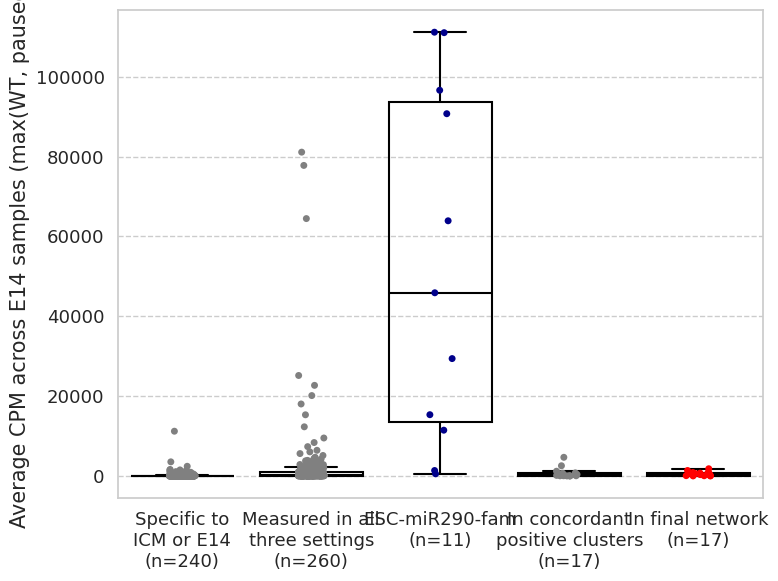

In [91]:
fig = plt.figure(figsize=(8,6))
ax1 = fig.add_subplot(1,1,1)

sns.boxplot(
    data=mirna_cpm_avg,
    x='selection_status',
    y='avg',
    order=[
        "specific_to_icm_or_e14",
        "measured_in_all_three_settings",
        "ESC-miR290-fam",
        "in_concordant_positive_clusters",
        "in_final_network",
    ],
    palette={
        "specific_to_icm_or_e14": "gray",
        "measured_in_all_three_settings": "gray",
        "ESC-miR290-fam": "darkblue",
        "in_concordant_positive_clusters": "gray",
        "in_final_network": "red",
    },
    showfliers=False,
    ax=ax1,
    **PROPS,
)

sns.stripplot(
    #data=mirna_cpm_avg.loc[lambda df: df['avg']<df['avg'].quantile(0.95),:],
    data=mirna_cpm_avg,
    x='selection_status',
    y='avg',
    order=[
        "specific_to_icm_or_e14",
        "measured_in_all_three_settings",
        "ESC-miR290-fam",
        "in_concordant_positive_clusters",
        "in_final_network",
    ],
    palette={
        "specific_to_icm_or_e14": "gray",
        "measured_in_all_three_settings": "gray",
        "ESC-miR290-fam": "darkblue",
        "in_concordant_positive_clusters": "gray",
        "in_final_network": "red",
    },
    ax=ax1,
)

rename_xticks = {
    "specific_to_icm_or_e14": "Specific to\nICM or E14",
    "measured_in_all_three_settings": "Measured in all\nthree settings",
    "ESC-miR290-fam": "ESC-miR290-fam",
    "in_concordant_positive_clusters": "In concordant\npositive clusters",
    "in_final_network": "In final network",
}

# Add numbers for the tick renamers
for k, v in rename_xticks.items():
    rename_xticks[k] = f"{v}\n(n={mirna_cpm_avg.loc[lambda df: df['selection_status'] == k,:].shape[0]})"


_ = ax1.set_xticklabels(
    [rename_xticks[t.get_text()] for t in ax1.get_xticklabels()],
    rotation=0, ha='center')

ax1.set_xlabel("")
ax1.set_ylabel("Average CPM across E14 samples (max(WT, paused)")

plt.show()

In [92]:
tmp = mirna_cpm_avg.groupby(['selection_status','quantile']).size().rename('count').reset_index()

tmp_cts = mirna_cpm_avg.groupby('selection_status').size().to_dict()

tmp['prop'] = tmp.apply(lambda row: row['count']/tmp_cts[row['selection_status']], axis=1)

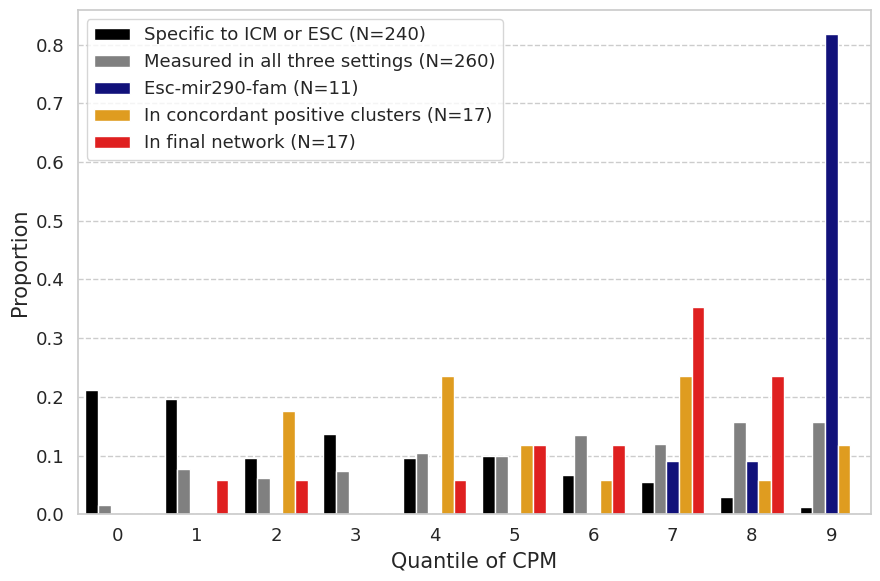

In [95]:

EXPORT = False

palette={
        'specific_to_icm_or_e14':'black',
        'measured_in_all_three_settings':'grey',
        'ESC-miR290-fam':'darkblue',
        'in_concordant_positive_clusters':'orange',
        'in_final_network':'red',
    }
fig = plt.figure(figsize=(9,6))
ax1 = fig.add_subplot(1,1,1)

sns.barplot(
    data=tmp,
    x='quantile',
    y='prop',
    hue='selection_status',
    palette=palette,
    hue_order=palette.keys(),
    ax = ax1,
)

ax1.legend(bbox_to_anchor=(0,1))
ax1.set_ylabel("Proportion")
ax1.set_xlabel("Quantile of CPM")

# Rename.

# Define a dictionary to rename legend handles

legend_labels = {}
for k, v in tmp.groupby("selection_status")['count'].sum().to_dict().items():
    k_new = k.replace('_', ' ')
    k_new = k_new.capitalize()
    k_new = k_new.replace("icm","ICM")
    k_new = k_new.replace("e14","ESC")
    legend_labels[f"{k}"] = f"{k_new} (N={v:,})"

# Get the handles and labels for the current axes
handles, labels = plt.gca().get_legend_handles_labels()
# Create a new list of handles with the renamed labels
new_handles = [h for h, l in zip(handles, labels) if l in legend_labels]
new_labels = [legend_labels[l] for l in labels if l in legend_labels]

# Create the legend with the new handles and labels
plt.legend(new_handles, new_labels, loc="upper left", )





if EXPORT:
    plt.savefig("./reviewers_miRNA_CPM_quantile_proportion.V2.pdf", bbox_inches='tight')
    plt.savefig("./reviewers_miRNA_CPM_quantile_proportion.V2.svg", bbox_inches='tight')

plt.show()


In [96]:
#threshold_quantile = 1.00
threshold_quantile = 0.95
x2 = mirna_cpm_avg.loc[lambda df: df['avg']<df['avg'].quantile(threshold_quantile),:].loc[lambda df: df['selection_status'] == 'measured_in_all_three_settings',:]
x1 = mirna_cpm_avg.loc[lambda df: df['avg']<df['avg'].quantile(threshold_quantile),:].loc[lambda df: df['selection_status'] == 'in_final_network',:]

scipy.stats.ttest_ind(x1['avg'], x2['avg'], equal_var=False, alternative='greater')

Ttest_indResult(statistic=-0.46866309981466403, pvalue=0.6782746348844798)

In [97]:
# Here: display the miRNAs from the network, so as to show their quantiles.
display(mirna_cpm_avg.loc[mirnas_net,:].sort_values(by='avg',ascending=False))

,avg,selection_status,quantile
#miRNA,,,
mmu-miR-23a-3p,1825.937891,in_final_network,8
mmu-miR-27b-3p,1383.573984,in_final_network,8
mmu-miR-429-3p,877.822396,in_final_network,8
mmu-miR-30b-5p,811.507923,in_final_network,8
mmu-miR-148a-3p,800.409930,in_final_network,7
mmu-miR-200b-3p,726.294402,in_final_network,7
mmu-miR-205-5p,705.435383,in_final_network,7
mmu-miR-141-3p,617.886702,in_final_network,7
mmu-miR-26b-5p,501.202838,in_final_network,7


In [102]:
# Now we will plot logFC = f(avg expression).
# We separate the three settings.
# We color differently the three sets of miRNAs: in positive cluster, in final network, other.

#SELECTED_CONDITION = "E14"
SELECTED_CONDITION = "ICM"
#SELECTED_CONDITION_LOGFC = "paused_E14"
#SELECTED_CONDITION_LOGFC = "diapaused_ICM"
SELECTED_CONDITION_LOGFC = "mTor_ICM"

QUANTITY_TYPE = "counts"
source_counts = mirna_cts_avg_per_ct

QUANTITY_TYPE = "CPM"
source_counts = mirna_cpm_avg_per_ct

mirna_cts_avg_SELECTED = source_counts.filter(regex=SELECTED_CONDITION).mean(axis=1).rename('avg').to_frame()

mirna_logfc_cts_SELECTED = pd.concat([
    mirna_cts_avg_SELECTED,
    mirna_dea_merged[SELECTED_CONDITION_LOGFC].rename('logFC'),
    ], axis=1).dropna()

mirna_logfc_cts_SELECTED['selection_status'] = "other_clusters"

mirna_logfc_cts_SELECTED.loc[
    lambda df: df.index.isin(mirnas_esc),
    'selection_status'
] = "ESC-miR290-fam"

mirna_logfc_cts_SELECTED.loc[mirna_dea_merged.loc[lambda df: df['cluster'].isin([1,8]),:].index.values, 'selection_status'] = "in_concordant_positive_clusters"

mirna_logfc_cts_SELECTED.loc[mirnas_net, 'selection_status'] = "in_final_network"

mirna_logfc_cts = mirna_logfc_cts_SELECTED

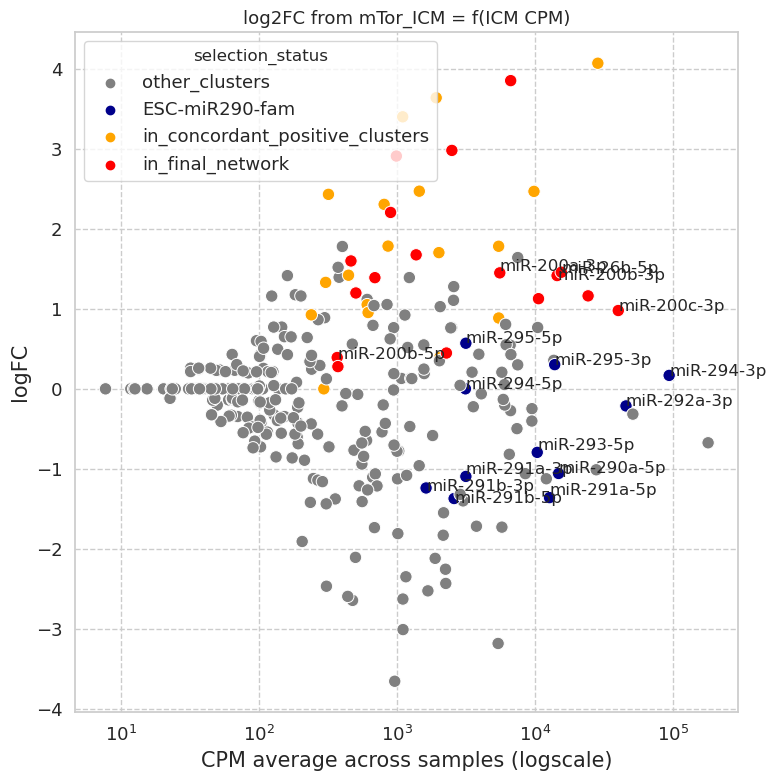

In [103]:
EXPORT = True


fig = plt.figure(figsize=(8, 8))
ax1 = fig.add_subplot(1, 1, 1)

sns.scatterplot(
    data=mirna_logfc_cts,
    x="avg",
    y="logFC",
    hue="selection_status",
    hue_order=[
        "other_clusters",
        "ESC-miR290-fam",
        "in_concordant_positive_clusters",
        "in_final_network",
    ],
    palette={
        "other_clusters": "gray",
        "ESC-miR290-fam": "darkblue",
        "in_concordant_positive_clusters": "orange",
        "in_final_network": "red",
    },
    ax=ax1,
    s=80,
)

# Add the names of validated miRNAs
for mirna_name, row in mirna_logfc_cts.reindex(mirnas_tested + mirnas_esc).iterrows():
    x = row["avg"]
    y = row["logFC"]
    ax1.annotate(
        mirna_name.split("mmu-")[1],
        (x, y),
        xytext=(x, y * (((np.random.random() - 0.5) / 10) + 1)),
        fontsize=12,
    )


ax1.set_xscale("log")
ax1.set_xlabel(f"{QUANTITY_TYPE} average across samples (logscale)")

ax1.set_title(
    f"log2FC from {SELECTED_CONDITION_LOGFC} = f({SELECTED_CONDITION} {QUANTITY_TYPE})"
)

plt.tight_layout()

if EXPORT:
    plt.savefig(
        f"./reviewers_miRNA_{SELECTED_CONDITION}_{SELECTED_CONDITION_LOGFC}_logFC_vs_{QUANTITY_TYPE}_avg.V2.svg",
        bbox_inches="tight",
    )


plt.show()

In [48]:
# We perform a t-test to check whether the miRNAs in the network show a higher logFC than the rest.

x1 = mirna_logfc_cts.loc[lambda df: df['logFC']>0,:].assign(abs_logFC=lambda df: df['logFC'].abs()).loc[lambda df: df['selection_status'] == 'in_final_network',:]

x2 = mirna_logfc_cts.loc[lambda df: df['logFC']>0,:].assign(abs_logFC=lambda df: df['logFC'].abs()).loc[lambda df: df['selection_status'] == 'other_clusters',:]

x3 = mirna_logfc_cts.loc[lambda df: df['logFC']>0,:].assign(abs_logFC=lambda df: df['logFC'].abs()).loc[lambda df: df['selection_status'] == 'in_concordant_positive_clusters',:]

print(scipy.stats.ttest_ind(x1['abs_logFC'], x2['abs_logFC'], equal_var=False, alternative="greater"))
print(scipy.stats.ttest_ind(x1['abs_logFC'], x3['abs_logFC'], equal_var=False, alternative="greater"))


Ttest_indResult(statistic=1.7832881563622933, pvalue=0.045176441813626074)
Ttest_indResult(statistic=1.7090043896641676, pvalue=0.04982578236394032)


/tmp/ipykernel_1639701/2502005054.py:35: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.stripplot(


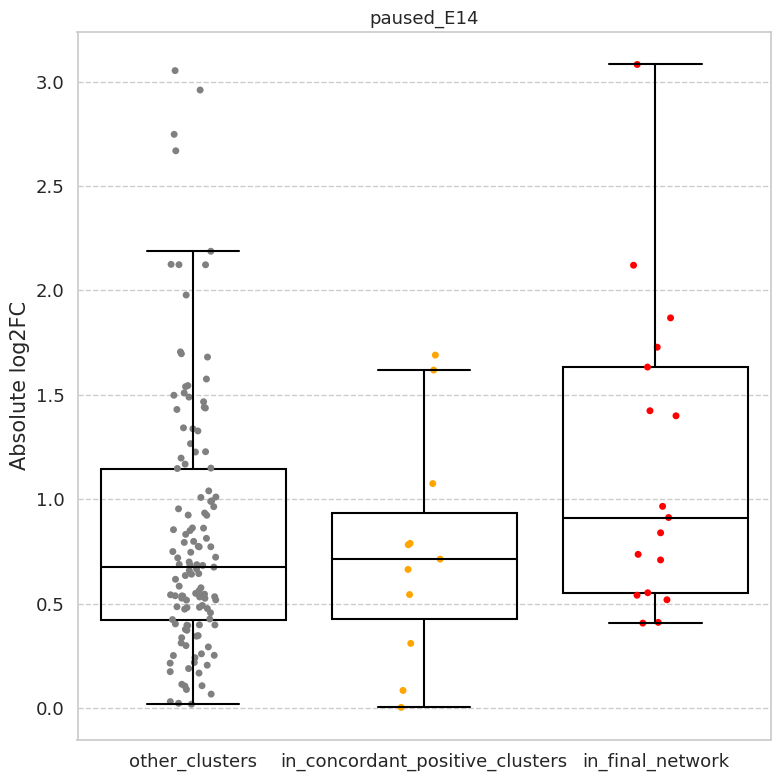

In [49]:
# Plot the logFC distribution of miRNAs in net, in pos cluster, or in other clusters.
EXPORT = False

fig = plt.figure(figsize=(8,8))
ax1 = fig.add_subplot(1,1,1)

PROPS = {
    'boxprops':{'facecolor':'none', 'edgecolor':'black'},
    'medianprops':{'color':'black'},
    'whiskerprops':{'color':'black'},
    'capprops':{'color':'black'}
}
#

sns.boxplot(
    data=mirna_logfc_cts.loc[lambda df: df['logFC']>0,:].assign(abs_logFC=lambda df: df['logFC'].abs()),
    y='abs_logFC',
    x='selection_status',
    order=[
        "other_clusters",
        "in_concordant_positive_clusters",
        "in_final_network",
    ],
    palette={
        "other_clusters": "gray",
        "in_concordant_positive_clusters": "orange",
        "in_final_network": "red",
    },
    showfliers=False,
    **PROPS,
    zorder=10,
    ax=ax1,
)

sns.stripplot(
    data=mirna_logfc_cts.loc[lambda df: df['logFC']>0,:].assign(abs_logFC=lambda df: df['logFC'].abs()),
    y='abs_logFC',
    x='selection_status',
    order=[
        "other_clusters",
        "in_concordant_positive_clusters",
        "in_final_network",
    ],
    palette={
        "other_clusters": "gray",
        "in_concordant_positive_clusters": "orange",
        "in_final_network": "red",
    },
    zorder=1,
    ax=ax1,
)

ax1.set_xlabel("")
ax1.set_ylabel("Absolute log2FC")

ax1.set_title(SELECTED_CONDITION_LOGFC)

plt.tight_layout()

if EXPORT:
    plt.savefig(f"./reviewers_miRNA_{SELECTED_CONDITION}_{SELECTED_CONDITION_LOGFC}_logFC_distribution.svg", bbox_inches='tight')


plt.show()

# Explore : properties of proteins in the network

In [50]:
t_filt_ppi = DATA['ppi']['filtered'][9]
t_filt_mirtarg = DATA['mirtarg']['filtered'][9]

t_filt_prot = set(t_filt_ppi['source'].unique()) | set(t_filt_ppi['target'].unique()) | set(t_filt_mirtarg['target'].unique())
t_filt_mirna = set(t_filt_mirtarg['source'].unique())

In [51]:
t_selected = DATA["final"]["ivv-ivt"]["edges"]
t_selected_prot = (
    set(t_selected.loc[lambda df: df["edge_type"] == "ppi", "source"].unique())
    | set(t_selected.loc[lambda df: df["edge_type"] == "ppi", "target"].unique())
    | set(
        t_selected.loc[
            lambda df: df["edge_type"] == "mirnas_targets", "target"
        ].unique()
    )
)

In [52]:
# Gather counts of ppi per protein

x1 = t_filt_ppi.groupby('source').apply(lambda g: set(g['target'].values))
x2 = t_filt_ppi.groupby('target').apply(lambda g: set(g['source'].values))

cts_edges = {}
keys = set(x1.keys()) | set(x2.keys())
for k in keys:
    cts_edges[k] = len(x1.get(k, set()) | x2.get(k, set()))

In [53]:
comparison_counts_ppi_finalnet_or_not = pd.Series(cts_edges, name='count_ppi').to_frame().reset_index().assign(is_in_final_net=lambda df: df['index'].isin(t_selected_prot)).sort_values(by=['index','count_ppi'])

In [54]:
comparison_counts_ppi_finalnet_or_not.head(3)

,index,count_ppi,is_in_final_net
1912,0610010K14Rik,2,False
1950,1700037H04Rik,9,False
4088,2410141K09Rik,3,False


In [55]:
# Add in the average median-scaled intensity
comparison_counts_ppi_finalnet_or_not = pd.merge(
    comparison_counts_ppi_finalnet_or_not,
    DATA['prot']['intensities_medscaled'].set_index('Gene names').mean(axis=1).rename('avg_median_scaled_intensity').to_frame(),
    left_on='index',
    right_index=True,
    how='left'
)

In [56]:
# TEST : are the numbers of PPI edges different for protein inside vs outside network.
scipy.stats.ttest_ind(
    comparison_counts_ppi_finalnet_or_not.loc[lambda df: df['is_in_final_net']==True,'count_ppi'],
    comparison_counts_ppi_finalnet_or_not.loc[lambda df: df['is_in_final_net']==False,'count_ppi'],
    equal_var=False,
)

Ttest_indResult(statistic=6.266983411386343, pvalue=9.162065995377296e-10)

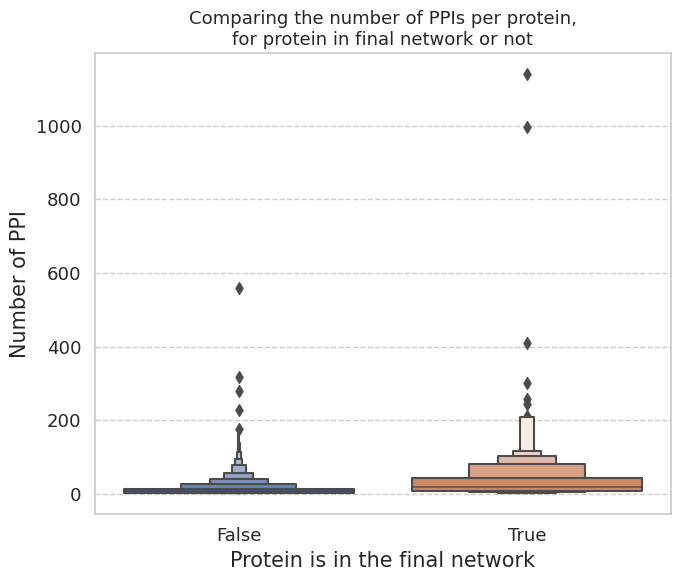

In [57]:
EXPORT = False


fig = plt.figure(figsize=(7,6))
ax1 = fig.add_subplot(1,1,1)

sns.boxenplot(
    data=comparison_counts_ppi_finalnet_or_not,
    x='is_in_final_net',
    y='count_ppi',
    ax=ax1,
)
ax1.set_title("Comparing the number of PPIs per protein,\nfor protein in final network or not")

ax1.set_ylabel("Number of PPI")
ax1.set_xlabel("Protein is in the final network")

plt.tight_layout()

if EXPORT:
    plt.savefig("./reviewers_ppi_counts_finalnet_vs_not.svg", bbox_inches='tight')

plt.show()


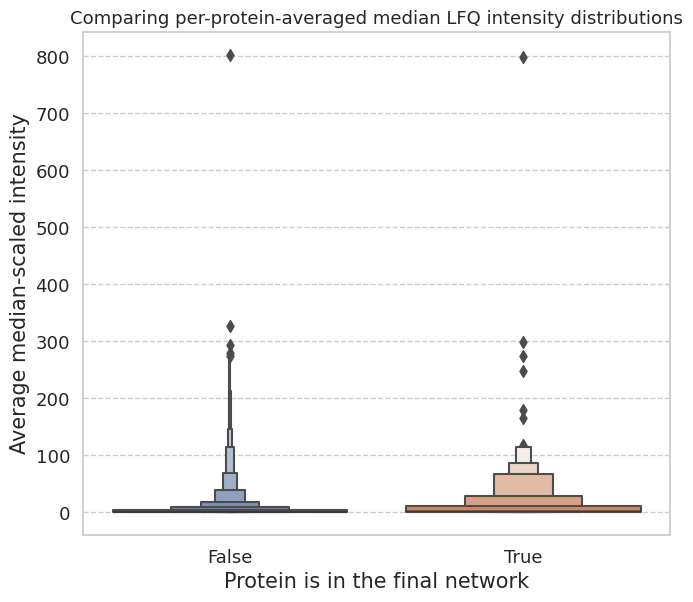

In [58]:
EXPORT = False

fig = plt.figure(figsize=(7,6))
ax1 = fig.add_subplot(1,1,1)

sns.boxenplot(
    data=comparison_counts_ppi_finalnet_or_not,
    x='is_in_final_net',
    y='avg_median_scaled_intensity',
    ax=ax1,
)


plt.tight_layout()
ax1.set_title("Comparing per-protein-averaged median LFQ intensity distributions")
ax1.set_ylabel("Average median-scaled intensity")
ax1.set_xlabel("Protein is in the final network")

if EXPORT:
    plt.savefig("./reviewers_median_scaled_intensity_finalnet_vs_not.svg", bbox_inches='tight')


In [59]:
scipy.stats.ttest_ind(
    comparison_counts_ppi_finalnet_or_not.loc[lambda df: df['is_in_final_net']==True,'avg_median_scaled_intensity'],
    comparison_counts_ppi_finalnet_or_not.loc[lambda df: df['is_in_final_net']==False,'avg_median_scaled_intensity'],
    equal_var=False,
)

Ttest_indResult(statistic=3.9714078464991434, pvalue=8.374059798911358e-05)

Here conclusions are : 

- indeed proteins in network have more PPIs than non-network proteins (i.e. greater chance to be selected)
- proteins in network have larger intensities than non-network proteins. Greater expression is associated with greater number of PPIs...


## PLOTS

#### CUMULATIVE PLOT logFC of targets vs non-targets

In [88]:
full_edges_mirtarg = DATA['mirtarg']['full']
sub_edges_mirtarg_from_network_mirnas = full_edges_mirtarg.loc[lambda df: df['source'].isin(mirnas_net),:]

subset_prots_not_in_net_but_mirtarg_of_network_mirnas = set(sub_edges_mirtarg_from_network_mirnas['target'].unique()) - prot_in_net_direct - prot_in_net_indirect

In [89]:
df = prot_ivt_dea.copy()
df['status_network'] = 'other'
df.loc[[p for p in subset_prots_not_in_net_but_mirtarg_of_network_mirnas if p in df.index.values],'status_network'] = 'mirtarg_not_in_net'
df.loc[[p for p in prot_in_net_direct if p in df.index.values],'status_network'] = 'network_mirtarg'


In [90]:
df.sort_values(by=['status_network', 'logFC'], inplace=True)
df['cumsum_proportion'] = df.groupby('status_network').cumcount() / df.groupby('status_network')['logFC'].transform('count')

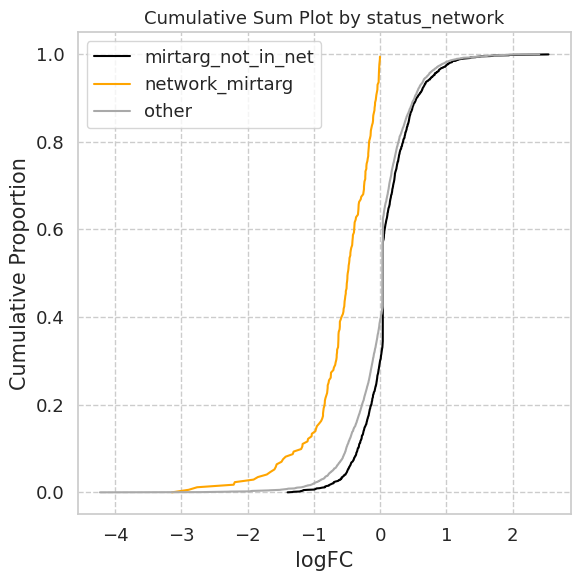

In [91]:
EXPORT = False


palette_targets = {
    'network_mirtarg':'orange',
    'mirtarg_not_in_net':'black',
    'network_ppi':'lightblue',
    'other':'darkgrey',
}
# Plotting
fig = plt.figure(figsize=(6, 6))
ax1 = fig.add_subplot(1,1,1,)

for group, data in df.groupby('status_network'):
    ax1.plot(data['logFC'], data['cumsum_proportion'], label=group, color=palette_targets[group])

ax1.set_title('Cumulative Sum Plot by status_network')
ax1.set_ylabel('Cumulative Proportion')
ax1.set_xlabel('logFC')

ax1.legend()
ax1.grid(True)

plt.tight_layout()

if EXPORT:
    plt.savefig("./reviewers_cumulative_sum_plot_status_network.IVT_PROT.svg", bbox_inches='tight')

plt.show()


# Numbers

## miRNA-targets

In [158]:

print(f"Total number of miRNAs in the gathered resources of edges: {DATA.mirtarg.full['source'].unique().shape[0]:,}")
print(f"Total number of proteins in these edges: {DATA.mirtarg.full['target'].unique().shape[0]:,}")

Total number of miRNAs in the gathered resources of edges: 1,998
Total number of proteins in these edges: 17,802


In [19]:
print(f"Total number of edges: {DATA['mirtarg']['full'].shape[0]:,}")

Total number of edges: 705,242


In [61]:
x = list(itt.chain(*DATA['mirtarg']['full'].metadata.apply(lambda meta: list(meta.keys())).values))

In [66]:
DATA['mirtarg']['full'].metadata.apply(lambda meta: tuple(meta.keys())).value_counts()

(mirdb,)               664660
(mirtarbase,)           30795
(mirdb, mirtarbase)      9787
Name: metadata, dtype: int64

In [64]:
pd.Series(x).value_counts().sum()

715029

In [23]:
for run_id in selected_run_ids:
    print(f"run_id={run_id} - after filter on nodes: number of edges without measured miRNA or protein: {DATA['mirtarg']['filtered'][run_id]['score'].isnull().sum():,}")
    print(f"run_id={run_id} - after filter on nodes: number of edges: {DATA['mirtarg']['filtered'][run_id].shape[0]:,}")
    print(f"run_id={run_id} - after filter on nodes: number of unique miRNAs: {DATA['mirtarg']['filtered'][run_id]['source'].unique().shape[0]:,}")
    print(f"run_id={run_id} - after filter on nodes: number of unique proteins: {DATA['mirtarg']['filtered'][run_id]['target'].unique().shape[0]:,}")
    print("\n")

run_id=2 - after filter on nodes: number of edges without measured miRNA or protein: 0
run_id=2 - after filter on nodes: number of edges: 80,099
run_id=2 - after filter on nodes: number of unique miRNAs: 558
run_id=2 - after filter on nodes: number of unique proteins: 5,019


run_id=9 - after filter on nodes: number of edges without measured miRNA or protein: 0
run_id=9 - after filter on nodes: number of edges: 5,234
run_id=9 - after filter on nodes: number of unique miRNAs: 24
run_id=9 - after filter on nodes: number of unique proteins: 2,104


run_id=13 - after filter on nodes: number of edges without measured miRNA or protein: 0
run_id=13 - after filter on nodes: number of edges: 5,234
run_id=13 - after filter on nodes: number of unique miRNAs: 24
run_id=13 - after filter on nodes: number of unique proteins: 2,104




In [160]:
DATA['mirtarg']['filtered'][9]['edge_concordance'].value_counts()

concordant    3271
discordant    1963
Name: edge_concordance, dtype: int64

In [164]:
for run_id in selected_run_ids:
    print(f"run_id={run_id} - after filter on nodes: number of edges without measured miRNA or protein: {DATA['mirtarg']['filtered'][run_id]['score'].isnull().sum():,}")

    tmp = DATA['mirtarg']['filtered'][run_id]['edge_concordance'].value_counts()
    print(tmp.apply(lambda v: f"{v:,}"))
    print((tmp/tmp.sum()*100).apply(lambda v: f"{v:,}"))
    print("\n")

run_id=2 - after filter on nodes: number of edges without measured miRNA or protein: 0
discordant    36,388
concordant    35,402
Name: edge_concordance, dtype: object
discordant    50.686725170636585
concordant     49.31327482936342
Name: edge_concordance, dtype: object


run_id=9 - after filter on nodes: number of edges without measured miRNA or protein: 0
concordant    3,271
discordant    1,963
Name: edge_concordance, dtype: object
concordant    62.495223538402755
discordant     37.50477646159725
Name: edge_concordance, dtype: object


run_id=13 - after filter on nodes: number of edges without measured miRNA or protein: 0
concordant    3,271
discordant    1,963
Name: edge_concordance, dtype: object
concordant    62.495223538402755
discordant     37.50477646159725
Name: edge_concordance, dtype: object




In [168]:
DATA['final'].keys()

odict_keys(['ivt-only', 'ivv-ivt', 'ivv-ivt_relaxed', 'getdoc'])

In [170]:
DATA['final']['ivt-only']['edges'].loc[lambda df: df['edge_type'] == 'mirnas_targets']['edge_concordance'].value_counts()

discordant    355
Name: edge_concordance, dtype: int64

## PPIs

In [11]:
print(f"Total number of edges: {DATA.ppi.full.shape[0]:,}")

Total number of edges: 84,363


In [12]:
x = len(set(DATA.ppi.full['source'].unique()) | set(DATA.ppi.full['target'].unique()))
print(f"Total number of proteins in the gathered resources of edges: {x:,}")

Total number of proteins in the gathered resources of edges: 12,896


In [13]:
for run_id in selected_run_ids:
    print(f"run_id={run_id} - after filter on nodes: number of edges without measured protein: {DATA['ppi']['filtered'][run_id]['score'].isnull().sum():,}")
    print(f"run_id={run_id} - after filter on nodes: number of edges: {DATA['ppi']['filtered'][run_id].shape[0]:,}")
    print(f"run_id={run_id} - after filter on nodes: number of unique proteins: {len(set(DATA['ppi']['filtered'][run_id]['source'].unique()) | set(DATA['ppi']['filtered'][run_id]['source'].unique())):,}")
    print("\n")

run_id=2 - after filter on nodes: number of edges without measured protein: 0
run_id=2 - after filter on nodes: number of edges: 34,846
run_id=2 - after filter on nodes: number of unique proteins: 3,526


run_id=9 - after filter on nodes: number of edges without measured protein: 0
run_id=9 - after filter on nodes: number of edges: 34,846
run_id=9 - after filter on nodes: number of unique proteins: 3,526


run_id=13 - after filter on nodes: number of edges without measured protein: 0
run_id=13 - after filter on nodes: number of edges: 34,846
run_id=13 - after filter on nodes: number of unique proteins: 3,526




In [14]:
for final in ['ivv-ivt', 'ivv-ivt_relaxed', 'ivt-only']:
    display(DATA['final'][final]['edges'].groupby('edge_type').size())

edge_type
mirnas_targets    196
ppi               335
dtype: int64

edge_type
mirnas_targets    588
ppi               335
dtype: int64

edge_type
mirnas_targets    355
ppi               337
dtype: int64

## Merged proteins from PPI + miRTarg

In [15]:

for run_id in selected_run_ids:
    print(f"run_id={run_id} - after filter on nodes: number of unique proteins: {len(set(DATA['ppi']['filtered'][run_id]['source'].unique()) | set(DATA['ppi']['filtered'][run_id]['source'].unique()) | set(DATA['mirtarg']['filtered'][run_id]['target'].unique())):,}")

run_id=2 - after filter on nodes: number of unique proteins: 5,422
run_id=9 - after filter on nodes: number of unique proteins: 4,346
run_id=13 - after filter on nodes: number of unique proteins: 4,346


# Exploring support of edges by TargetScan

Here I want to explore the support of final mirtarg edges when compared against TargetScan.

In [22]:
ll ../../../storage/MANUAL_DATA/RESOURCES/TargetScan/processed/

total 56136
-rw-r--r-- 1 l10n 51436486 Oct 16 17:52 mmu_targetscan_edges.conserved_family.tsv
-rw-r--r-- 1 l10n  6041961 Oct 16 17:08 mmu_targetscan_edges.tsv


In [23]:
path = "../../../storage/MANUAL_DATA/RESOURCES/TargetScan/processed/mmu_targetscan_edges.conserved_family.tsv"
targetscan_conserved = pd.read_csv(path, header=0, index_col=None, sep="\t")

targetscan_conserved['source'] = targetscan_conserved['source'].str.split('-', n=1, expand=True).iloc[:,1].values

path = "../../../storage/MANUAL_DATA/RESOURCES/TargetScan/processed/mmu_targetscan_edges.nonconserved_family.tsv"
targetscan_nonconserved = pd.read_csv(path, header=0, index_col=None, sep="\t")

targetscan_nonconserved['source'] = targetscan_nonconserved['source'].str.split('-', n=1, expand=True).iloc[:,1].values

In [32]:
DATA['final'].keys()

odict_keys(['ivt-only', 'ivv-ivt', 'ivv-ivt_relaxed'])

In [36]:
tmp_final_mirtarg = DATA['final']['ivt-only']['edges'].loc[
    lambda df: df['edge_type']=='mirnas_targets',
    ['source','target']
]

In [27]:
set_targetscan_conserved = set(targetscan_conserved.apply(tuple, axis=1).values)
set_targetscan_nonconserved = set(targetscan_nonconserved.apply(tuple, axis=1).values)

In [37]:
set_tmp_final_mirtarg = set(tmp_final_mirtarg.apply(tuple, axis=1).values)

In [38]:
print(len(set_targetscan_conserved & set_tmp_final_mirtarg), len(set_tmp_final_mirtarg))
print(len(set_targetscan_nonconserved & set_tmp_final_mirtarg), len(set_tmp_final_mirtarg))
print(len((set_targetscan_nonconserved | set_targetscan_conserved) & set_tmp_final_mirtarg), len(set_tmp_final_mirtarg))

189 355
160 355
341 355


In [86]:
print(len(set_targetscan & set_tmp_final_mirtarg), len(set_tmp_final_mirtarg))

174 196


In [69]:
tmp_final_mirtarg

,source,target
0,miR-141-3p,Flnb
1,miR-200a-3p,Flnb
10,miR-148a-3p,Abcb7
11,miR-148a-3p,Arfip1
12,miR-148a-3p,Atp2a2
...,...,...
275,miR-27b-3p,Ank2
276,miR-30b-5p,Hnrnpul2
277,miR-30d-5p,Hnrnpul2
283,miR-30d-5p,Eml4


# Largest logFC nodes and edge scores in final networks

## Largest logFC nodes

In [16]:
node_to_logfc = DotMap()

for network in ['ivt-only', 'ivv-ivt', 'ivv-ivt_relaxed']:
    tmp = pd.concat(
        [
            DATA['final'][network]['edges'].loc[lambda df: df['edge_type'] == 'ppi', :].apply(lambda row: pd.Series([row['source'], row['source_metadata']['log2fc']], index=['node','log2fc']), axis=1),
            DATA['final'][network]['edges'].loc[lambda df: df['edge_type'] == 'ppi', :].apply(lambda row: pd.Series([row['target'], row['target_metadata']['log2fc']], index=['node','log2fc']), axis=1),
            DATA['final'][network]['edges'].loc[lambda df: df['edge_type'] == 'mirnas_targets', :].apply(lambda row: pd.Series([row['target'], row['target_metadata']['log2fc']], index=['node','log2fc']), axis=1),
        ], axis=0
    )

    node_to_logfc[network]['proteins'] = tmp.drop_duplicates()

    tmp = DATA['final'][network]['edges'].loc[lambda df: df['edge_type'] == 'mirnas_targets', :].apply(lambda row: pd.Series([row['source'], row['source_metadata']['log2fc']], index=['node','log2fc']), axis=1)
    node_to_logfc[network]['mirnas'] = tmp.drop_duplicates()

In [18]:
node_to_logfc['ivv-ivt']['proteins'].sort_values(
    by='log2fc', ascending=True
).reset_index(drop=True).head(10)

,node,log2fc
0,Pml,-3.139341
1,Flnb,-2.888217
2,Esrp1,-2.760548
3,Pdcd11,-2.709469
4,Msh2,-2.592138
5,Ddx49,-2.495310
6,Huwe1,-2.313565
7,Kdm5b,-2.287804
8,Snrnp200,-2.260271
9,Numa1,-2.209446


In [19]:
node_to_logfc['ivv-ivt']['mirnas'].sort_values(
    by='log2fc', ascending=False
).reset_index(drop=True).head(10)

,node,log2fc
0,miR-26b-5p,3.082136
1,miR-200b-5p,2.120523
2,miR-200c-3p,1.868178
3,miR-148a-3p,1.727824
4,miR-1839-5p,1.632651
5,miR-200b-3p,1.423348
6,miR-429-3p,1.399124
7,miR-503-3p,0.965473
8,miR-30d-5p,0.911987
9,miR-200a-3p,0.838676


## Largest edge scores

In [75]:
for network in ['ivt-only', 'ivv-ivt', 'ivv-ivt_relaxed']:
    print(network)
    display(DATA['final'][network]['edges'].loc[lambda df: df['edge_type']=='ppi',:].sort_values(by='score', ascending=True).loc[:,['source','target','score']].head(30))
    display(DATA['final'][network]['edges'].loc[lambda df: df['edge_type']=='mirnas_targets',:].sort_values(by='score', ascending=True).loc[:,['source','target','score']].head(30))

ivt-only


,source,target,score
283,Ddx52,Pdcd11,-4.553923
101,Huwe1,Hnrnpul2,-4.506477
316,Utp20,Pdcd11,-4.390656
157,Huwe1,Eef2,-4.286688
40,Dhx15,Snrnp200,-4.169525
558,Eef2,Pgd,-4.008888
172,Huwe1,Rpl15,-3.801534
449,Snrnp200,Rbm39,-3.681121
29,Dhx15,Ddx42,-3.677252
586,Sf3b2,Snrnp200,-3.645416


,source,target,score
137,miR-677-5p,Tnpo1,2.889097
491,miR-340-5p,Hells,2.889636
195,miR-190a-3p,Actr10,2.891424
423,miR-27b-5p,Apmap,2.894541
127,miR-148a-3p,Tnpo1,2.897212
25,miR-871-5p,Dhx15,2.898210
269,miR-200c-3p,Xpot,2.898828
487,miR-340-5p,Copb1,2.903666
492,miR-340-5p,Ncor1,2.903967
204,miR-190a-3p,Nupl1,2.906657


ivv-ivt


,source,target,score
135,Ddx52,Pdcd11,-4.553923
281,Huwe1,Hnrnpul2,-4.506477
324,Utp20,Pdcd11,-4.390656
396,Huwe1,Eef2,-4.286688
167,Dhx15,Snrnp200,-4.169525
327,Eef2,Pgd,-4.008888
45,Huwe1,Rpl15,-3.801534
369,Snrnp200,Rbm39,-3.681121
156,Dhx15,Ddx42,-3.677252
358,Sf3b2,Snrnp200,-3.645416


,source,target,score
65,miR-429-3p,Pls3,2.251246
85,miR-200b-5p,Zbtb11,2.252069
95,miR-200c-3p,Atl2,2.252618
102,miR-200c-3p,Erc1,2.256491
57,miR-200b-3p,Eif5b,2.257009
11,miR-148a-3p,Arfip1,2.269101
275,miR-27b-3p,Ank2,2.269813
58,miR-200b-3p,Pls3,2.275470
112,miR-200c-3p,Nrbp1,2.280880
86,miR-27b-3p,Nxf1,2.282921


ivv-ivt_relaxed


,source,target,score
531,Ddx52,Pdcd11,-4.553923
669,Huwe1,Hnrnpul2,-4.506477
729,Utp20,Pdcd11,-4.390656
794,Huwe1,Eef2,-4.286688
567,Dhx15,Snrnp200,-4.169525
732,Eef2,Pgd,-4.008888
246,Huwe1,Rpl15,-3.801534
771,Snrnp200,Rbm39,-3.681121
556,Dhx15,Ddx42,-3.677252
760,Sf3b2,Snrnp200,-3.645416


,source,target,score
168,miR-27b-3p,Nsd1,1.544036
288,miR-200b-3p,Fam118b,1.551374
142,miR-200b-3p,Cnot6,1.556423
675,miR-30d-5p,Igf2r,1.561965
657,miR-322-5p,Ank2,1.563454
411,miR-429-3p,Rbfox2,1.564723
682,miR-30d-5p,Rbm25,1.564824
524,miR-205-5p,Ccdc93,1.565227
323,miR-200b-3p,Vat1l,1.566174
528,miR-205-5p,Inppl1,1.566285


# Enrichment in DE proteins

Here for each fo the final networks, we want to check whether the selection process lead to enriching for differentially expressed proteins.

In [20]:
de_down_proteins = set(DATA['prot']['dea'].loc[
    lambda df: (df['significant']) & (df['logFC']<0),
    :
].index.values)
down_proteins = set(DATA['prot']['dea'].loc[
    lambda df: (df['logFC']<0),
    :
].index.values)


enrichment_results = DotMap()
for network in ['ivt-only', 'ivv-ivt', 'ivv-ivt_relaxed']:

    network_proteins = set(DATA['final'][network]['proteins'].values)
    cts_matrix = [
            [len(network_proteins & de_down_proteins), len(network_proteins - de_down_proteins)],
            [len(de_down_proteins - network_proteins), len(down_proteins - de_down_proteins - network_proteins)],
    ]

    stat_res = scipy.stats.fisher_exact(cts_matrix, alternative='greater')
    enrichment_results[network]['count_matrix'] = cts_matrix
    enrichment_results[network]['stat'] = stat_res
    print(f"Network: {network}, {stat_res[1]}")

Network: ivt-only, 5.325338699031373e-35
Network: ivv-ivt, 1.3269660153183894e-30
Network: ivv-ivt_relaxed, 7.434549444416657e-26


In [150]:
enrichment_results['ivv-ivt']['count_matrix']

[[119, 312], [122, 1734]]

# Plots

## Filtering PPI: score distribution and filter threshold(s)

In [22]:
for run_id in selected_run_ids:
    print(run_id)
    display(DATA['configs']['runs'][run_ids[run_id]]['filtering_edges'])

2


{'mirnas_targets': {'keep_concordance_status': 'discordant',
  'method': 'quantile',
  'side': 'up',
  'quantile': 0.01},
 'ppi': {'keep_concordance_status': None,
  'method': 'quantile',
  'side': 'down',
  'quantile': 0.01}}

9


{'mirnas_targets': {'keep_concordance_status': 'discordant',
  'method': 'quantile',
  'side': 'up',
  'quantile': 0.1},
 'ppi': {'keep_concordance_status': None,
  'method': 'quantile',
  'side': 'down',
  'quantile': 0.01}}

13


{'mirnas_targets': {'keep_concordance_status': 'discordant',
  'method': 'quantile',
  'side': 'up',
  'quantile': 0.3},
 'ppi': {'keep_concordance_status': None,
  'method': 'quantile',
  'side': 'down',
  'quantile': 0.01}}

In [23]:
SAVEFIG = True
SAVEFIG_FILE = "./SupplementaryFigure_S5A_edge-score-distributions_w_thresholds.svg"

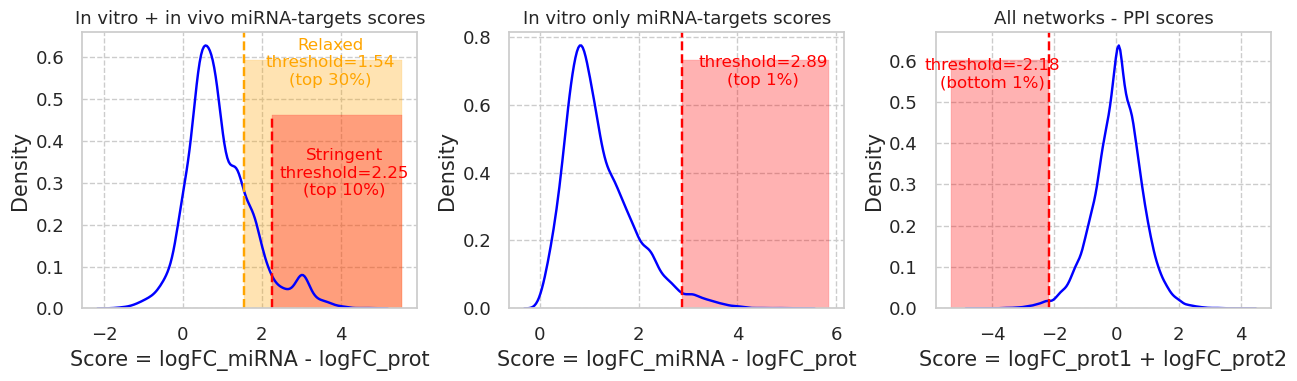

In [25]:
fig = plt.figure(figsize=(13,4))

# Ax1 = IVV-IVT, stringent+relaxed thresholds
# Ax2 = IVT-only
# Ax3 = PPI, all three MO networks

ax1 = fig.add_subplot(1,3,1)
ax2 = fig.add_subplot(1,3,2)
ax3 = fig.add_subplot(1,3,3)

# miRNA-targets - IVV-IVT
# -----------------------

# Note: here we can use either of the two mirtarg networks (stringent or relaxed thresholds)
# for the distribution of mirtarg-edges scores.

sns.kdeplot(
    data=DATA['mirtarg']['filtered'][9]['score'],
    color='blue',
    ax=ax1,
)

# Here we have two thresholds to set:
# - Stringent = top 10%
# - Relaxed = top 30%


# Get the lowest logFC value passing the threshold (i.e. in the final network)
x_mirtarg = DATA['final']['ivv-ivt_relaxed']['edges'].loc[lambda df: df['edge_type']=='mirnas_targets','score'].min()
qt_mirtarg = DATA['configs']['runs'][run_ids[13]]['filtering_edges']['mirnas_targets']['quantile']

xmax = ax1.get_xlim()[1]

ax1.axvline(
    x=x_mirtarg,
    linestyle='--',
    color='orange',
)

ax1.axvspan(
    xmin=x_mirtarg,
    xmax=xmax,
    ymin=0.0,
    ymax=0.9,
    alpha=0.3,
    color='orange'
)

ax1.text(
    x=ax1.get_xlim()[1] - ((ax1.get_xlim()[1] - x_mirtarg)/2 ),
    y=ax1.get_ylim()[1]*0.8,
    s=f"Relaxed\nthreshold={x_mirtarg:.2f}\n(top {qt_mirtarg:.0%})",
    color='orange',
    horizontalalignment='center',
    verticalalignment='bottom',
    rotation=0,
    fontsize=12,
)

# Get the lowest logFC value passing the threshold (i.e. in the final network)
x_mirtarg = DATA['final']['ivv-ivt']['edges'].loc[lambda df: df['edge_type']=='mirnas_targets','score'].min()
qt_mirtarg = DATA['configs']['runs'][run_ids[9]]['filtering_edges']['mirnas_targets']['quantile']

ax1.axvline(
    x=x_mirtarg,
    ymax=0.7,
    linestyle='--',
    color='red',
)

ax1.axvspan(
    xmin=x_mirtarg,
    xmax=xmax,
    ymin=0.0,
    ymax=0.7,
    alpha=0.3,
    color='red'
)

ax1.text(
    x=ax1.get_xlim()[1] - ((ax1.get_xlim()[1] - x_mirtarg)/2 ),
    y=ax1.get_ylim()[1]*0.4,
    s=f"Stringent\nthreshold={x_mirtarg:.2f}\n(top {qt_mirtarg:.0%})",
    color='red',
    horizontalalignment='center',
    verticalalignment='bottom',
    rotation=0,
    fontsize=12,
)


ax1.set_title("In vitro + in vivo miRNA-targets scores")
ax1.set_xlabel("Score = logFC_miRNA - logFC_prot")

# miRNA-targets - IVT only
# ------------------------

# Full distribution of scores
sns.kdeplot(
    data=DATA['mirtarg']['filtered'][2].loc[
        lambda df: (df['edge_concordance']=='discordant') & \
                    (df['source_metadata'].apply(lambda v: v.get('log2fc')>0)),
        'score'],
    color='blue',
    ax=ax2,
)

# Get the lowest logFC value passing the threshold (i.e. in the final network)
x_mirtarg = DATA['final']['ivt-only']['edges'].loc[lambda df: df['edge_type']=='mirnas_targets','score'].min()
qt_mirtarg = DATA['configs']['runs'][run_ids[2]]['filtering_edges']['mirnas_targets']['quantile']


ax2.axvline(
    x=x_mirtarg,
    linestyle='--',
    color='red',
)

ax2.axvspan(
    xmin=ax2.get_xlim()[1],
    xmax=x_mirtarg,
    ymin=0.0,
    ymax=0.9,
    alpha=0.3,
    color='red'
)

ax2.text(
    x=ax2.get_xlim()[1] - ((ax2.get_xlim()[1] - x_mirtarg)/2 ),
    y=ax2.get_ylim()[1]*0.8,
    s=f"threshold={x_mirtarg:.2f}\n(top {qt_mirtarg:.0%})",
    color='red',
    horizontalalignment='center',
    verticalalignment='bottom',
    rotation=0,
    fontsize=12,
)

ax2.set_title("In vitro only miRNA-targets scores")
ax2.set_xlabel("Score = logFC_miRNA - logFC_prot")

# PPI
# ---

sns.kdeplot(
    data=DATA['ppi']['filtered'][2]['score'],
    color='blue',
    ax=ax3,
)

x_ppi = DATA['final']['ivt-only']['edges'].loc[lambda df: df['edge_type']=='ppi','score'].max()
ax3.axvline(
    x=x_ppi,
    linestyle='--',
    color='red',
)
qt_ppi = DATA['configs']['runs'][run_ids[2]]['filtering_edges']['ppi']['quantile']

ax3.axvspan(
    xmin=ax3.get_xlim()[0],
    xmax=x_ppi,
    ymin=0.0,
    ymax=0.9,
    alpha=0.3,
    color='red'
)

ax3.text(
    x=x_ppi - ((x_ppi - ax3.get_xlim()[0])/2 ),
    y=ax1.get_ylim()[1]*0.8,
    s=f"threshold={x_ppi:.2f}\n(bottom {qt_ppi:.0%})",
    color='red',
    horizontalalignment='center',
    verticalalignment='bottom',
    rotation=0,
    fontsize=12,
)

ax3.set_xlabel("Score = logFC_prot1 + logFC_prot2")


ax3.set_title("All networks - PPI scores")

plt.tight_layout()

if SAVEFIG:
    plt.savefig(SAVEFIG_FILE, dpi=300, bbox_inches='tight')

plt.show()

# Other

In [288]:
DATA['final']['ivv-ivt_relaxed']['edges']['target_metadata'].iloc[0].keys()

dict_keys(['log2fc', 'adj_pval', 'DE_status', 'significant'])

## Relaxed network : Let-7 targets

In [295]:
DATA['final']['ivv-ivt_relaxed']['edges'].loc[
    lambda df: df['source'].str.startswith('let-7'),
    :
].assign(
    DE_status_prot = lambda df: df['target_metadata'].apply(lambda v: v.get('DE_status')),
    log2fc_prot = lambda df: df['target_metadata'].apply(lambda v: v.get('log2fc')),
    log2fc_adjpval = lambda df: df['target_metadata'].apply(lambda v: v.get('adj_pval')),
).loc[:,['source','target','score','DE_status_prot','log2fc_prot','log2fc_adjpval']].sort_values(by='target')

,source,target,score,DE_status_prot,log2fc_prot,log2fc_adjpval
0,let-7d-5p,Chd4,1.888367,DOWN,-1.106863,0.004833
8,let-7g-5p,Chd4,1.649644,DOWN,-1.106863,0.004833
1,let-7d-5p,Cpsf4,1.694178,notSign,-0.912674,0.509531
2,let-7d-5p,Galnt1,1.944902,notSign,-1.163398,0.528634
10,let-7g-5p,Galnt1,1.706179,notSign,-1.163398,0.528634
3,let-7d-5p,Hmgcl,1.589835,notSign,-0.808331,0.437235
4,let-7d-5p,Msi2,1.638127,notSign,-0.856623,0.443573
25,let-7g-5p,Mttp,1.728930,notSign,-1.186149,0.547338
5,let-7d-5p,Sall4,1.643319,DOWN,-0.861815,0.017181
6,let-7d-5p,Thoc2,1.830056,DOWN,-1.048552,0.017258


# Assembling supplementary table 7

In [11]:
EXPORT_TABLE = True

In [27]:
path = "SupplementaryTable_S7_final-network-edges.xlsx"

if EXPORT_TABLE:
    with pd.ExcelWriter(path, date_format=None, mode='w') as out_obj:
        DATA['final']['ivv-ivt']['edges'].drop(columns='index').to_excel(
            out_obj,
            sheet_name="ESC-ICM UP miR-targ-ppi - main",
            index=False,
            header=True,
            )
        DATA['final']['ivv-ivt_relaxed']['edges'].drop(columns='index').to_excel(
            out_obj,
            sheet_name="ESC-ICM UP miR-targ-ppi - relax",
            index=False,
            header=True,
            )
        DATA['final']['ivt-only']['edges'].drop(columns='index').to_excel(
            out_obj,
            sheet_name="ESC-only UP miR-targ-ppi",
            index=False,
            header=True,
            )


# TMP

In [21]:
DATA['final']['ivv-ivt']['edges'].loc[lambda df: df['edge_type'] == 'ppi',:].sort_values(by='score', ascending=False).head(4)

,index,source,target,metadata,score,source_metadata,target_metadata,edge_concordance,score_to_rank,score_ranked,score_ranked_description,edge_type,source_type,target_type
492,385,Nfrkb,Uchl5,"{""stringdb"": {""666830"": {""index"": ""666830"", ""e...",-2.176276,"{'log2fc': -1.6633871806908602, 'adj_pval': 0....","{'log2fc': -0.5128887684011879, 'adj_pval': 0....",concordant,-2.176276,0.990013,below_lower_threshold,ppi,gene,gene
88,394,Nxf1,Map1a,"{""biogrid"": {""824218"": {""Source Database"": ""BI...",-2.177397,"{'log2fc': -1.5742290343284198, 'adj_pval': 0....","{'log2fc': -0.6031674941621981, 'adj_pval': 0....",concordant,-2.177397,0.990042,below_lower_threshold,ppi,gene,gene
507,444,Polr2a,Nelfe,"{""biogrid"": {""2683009"": {""Source Database"": ""B...",-2.178299,"{'log2fc': -1.9537962546943104, 'adj_pval': 0....","{'log2fc': -0.2245028744534089, 'adj_pval': 0....",concordant,-2.178299,0.990071,below_lower_threshold,ppi,gene,gene
455,317,Hnrnpl,Hnrnpu,"{""biogrid"": {""2681207"": {""Source Database"": ""B...",-2.179732,"{'log2fc': -1.48580344871673, 'adj_pval': 0.03...","{'log2fc': -0.6939283657316538, 'adj_pval': 0....",concordant,-2.179732,0.990099,below_lower_threshold,ppi,gene,gene


In [22]:
DATA['final']['ivv-ivt']['edges'].loc[
    lambda df: df['edge_type'] == 'mirnas_targets',
    :
].sort_values(by='score', ascending=True).head(4)

,index,source,target,metadata,score,source_metadata,target_metadata,edge_concordance,score_to_rank,score_ranked,score_ranked_description,edge_type,source_type,target_type
65,191,miR-429-3p,Pls3,"{""mirdb"": {""169290"": {""index"": 169290, ""score""...",2.251246,"{'log2fc': 1.39912405376664, 'adj_pval': 0.773...","{'log2fc': -0.852121449754432, 'adj_pval': 0.0...",discordant,2.251246,0.099847,above_upper_threshold,mirnas_targets,miRNA,gene
85,42,miR-200b-5p,Zbtb11,"{""mirdb"": {""769786"": {""index"": 769786, ""score""...",2.252069,"{'log2fc': 2.12052288838421, 'adj_pval': 1.0, ...","{'log2fc': -0.131546558452324, 'adj_pval': 0.7...",discordant,2.252069,0.099338,above_upper_threshold,mirnas_targets,miRNA,gene
95,45,miR-200c-3p,Atl2,"{""mirdb"": {""837102"": {""index"": 837102, ""score""...",2.252618,"{'log2fc': 1.86817822559835, 'adj_pval': 0.546...","{'log2fc': -0.384439854810021, 'adj_pval': 0.4...",discordant,2.252618,0.098828,above_upper_threshold,mirnas_targets,miRNA,gene
102,54,miR-200c-3p,Erc1,"{""mirdb"": {""162417"": {""index"": 162417, ""score""...",2.256491,"{'log2fc': 1.86817822559835, 'adj_pval': 0.546...","{'log2fc': -0.388312328417822, 'adj_pval': 0.0...",discordant,2.256491,0.098319,above_upper_threshold,mirnas_targets,miRNA,gene


In [31]:
tmp2 = pd.concat([
    DATA['final']['ivv-ivt']['edges'].loc[lambda df: df['edge_type'] == 'mirnas_targets',['source','source_metadata']].rename(columns={'source':'gene','source_metadata':'gene_metadata'}),
], axis=0).drop_duplicates(subset='gene', keep='first').reset_index(drop=True)

tmp2['log2fc'] = tmp2['gene_metadata'].apply(lambda v: v['log2fc'])

In [32]:
tmp2.sort_values(by='log2fc', ascending=False)

,gene,gene_metadata,log2fc
4,miR-26b-5p,"{'log2fc': 3.08213571145658, 'adj_pval': 0.093...",3.082136
9,miR-200b-5p,"{'log2fc': 2.12052288838421, 'adj_pval': 1.0, ...",2.120523
3,miR-200c-3p,"{'log2fc': 1.86817822559835, 'adj_pval': 0.546...",1.868178
2,miR-148a-3p,"{'log2fc': 1.72782442509445, 'adj_pval': 0.378...",1.727824
5,miR-1839-5p,"{'log2fc': 1.63265051990513, 'adj_pval': 1.0, ...",1.632651
7,miR-200b-3p,"{'log2fc': 1.42334821106297, 'adj_pval': 0.888...",1.423348
8,miR-429-3p,"{'log2fc': 1.39912405376664, 'adj_pval': 0.773...",1.399124
16,miR-503-3p,"{'log2fc': 0.965473444041463, 'adj_pval': 1.0,...",0.965473
6,miR-30d-5p,"{'log2fc': 0.911986628759, 'adj_pval': 1.0, 'm...",0.911987
1,miR-200a-3p,"{'log2fc': 0.838675825601373, 'adj_pval': 1.0,...",0.838676


In [33]:
tmp = pd.concat([
    DATA['final']['ivv-ivt']['edges'].loc[
            lambda df: df['edge_type'] == 'mirnas_targets',
            ['target','target_metadata', 'edge_type']
        ].rename(columns={'target':'gene','target_metadata':'gene_metadata'}),

    DATA['final']['ivv-ivt']['edges'].loc[
            lambda df: df['edge_type'] == 'ppi',
            ['source','source_metadata','edge_type']
        ].rename(columns={'source':'gene','source_metadata':'gene_metadata'}),

    DATA['final']['ivv-ivt']['edges'].loc[
            lambda df: df['edge_type'] == 'ppi',
            ['target','target_metadata','edge_type']
        ].rename(columns={'target':'gene','target_metadata':'gene_metadata'}),
], axis=0)

In [34]:
tmp['log2fc'] = tmp['gene_metadata'].apply(lambda v: v['log2fc'])

In [38]:
tmp.loc[lambda df: df['gene'].isin(['Rpl7','Rpl3'])]

,gene,gene_metadata,edge_type,log2fc
49,Rpl7,"{'log2fc': -0.890015131486973, 'adj_pval': 0.0...",ppi,-0.890015
46,Rpl3,"{'log2fc': -0.693622681543724, 'adj_pval': 0.0...",ppi,-0.693623
473,Rpl3,"{'log2fc': -0.693622681543724, 'adj_pval': 0.0...",ppi,-0.693623
474,Rpl7,"{'log2fc': -0.890015131486973, 'adj_pval': 0.0...",ppi,-0.890015


In [37]:
tmp.sort_values(by='log2fc').drop_duplicates(subset=['gene','edge_type'], keep='first')

,gene,gene_metadata,edge_type,log2fc
136,Pml,"{'log2fc': -3.1393405515523, 'adj_pval': 0.027...",mirnas_targets,-3.139341
141,Pml,"{'log2fc': -3.1393405515523, 'adj_pval': 0.027...",ppi,-3.139341
3,Flnb,"{'log2fc': -2.88821696167266, 'adj_pval': 0.00...",ppi,-2.888217
0,Flnb,"{'log2fc': -2.88821696167266, 'adj_pval': 0.00...",mirnas_targets,-2.888217
152,Esrp1,"{'log2fc': -2.7605483015028702, 'adj_pval': 0....",mirnas_targets,-2.760548
...,...,...,...,...
288,Cebpz,"{'log2fc': 0.512768969186468, 'adj_pval': 0.01...",ppi,0.512769
318,Ttc4,"{'log2fc': 0.514540262980432, 'adj_pval': 0.23...",ppi,0.514540
6,Itgb1,"{'log2fc': 0.5227670036337849, 'adj_pval': 0.1...",ppi,0.522767
150,Ube3a,"{'log2fc': 0.6424483613758011, 'adj_pval': 0.2...",ppi,0.642448
